# COVID-19 Data Analysis
- Data is provided Johns Hopkins University <a href='https://github.com/CSSEGISandData/COVID-19'>here</a>

In [1]:
# Import libraries
import shutil
import os
import stat
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from tensorflow import keras
import tensorflow as tf
import numpy as np
import folium
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import tensorflow_addons as tfa

%matplotlib inline

In [2]:
# Setting up colab directory path
WORKING_DIR = "drive/My Drive/colab/covid-19-analysis"

In [3]:
# Declare important variables
raw_data_path = f'{WORKING_DIR}/raw_data/'
confirmed_data_path = raw_data_path + 'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
death_data_path = raw_data_path + 'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
recovered_data_path = raw_data_path + 'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [4]:
# Run this cell to get latest data (For local)
# def handle_remove_readonly(func, path, exc):
#     if not os.access(path, os.W_OK):
#         os.chmod(path, stat.S_IWUSR)
#         func(path)
#     else:
#         raise
        
# if(os.path.exists(raw_data_path)):
#     shutil.rmtree(raw_data_path, onerror=handle_remove_readonly)
    
# !git clone https://github.com/CSSEGISandData/COVID-19.git $raw_data_path

In [5]:
# Run this cell to get latest data (For google colab)
!rm -rf $raw_data_path
!git clone 'https://github.com/CSSEGISandData/COVID-19.git' '$raw_data_path'

fatal: destination path 'drive/My Drive/colab/covid-19-analysis/raw_data' already exists and is not an empty directory.


## Data Analysis

### Worldwide cases analytic

In [6]:
# Declare dataframe
df_confirmed = pd.read_csv(confirmed_data_path)
df_death = pd.read_csv(death_data_path)
df_recovered = pd.read_csv(recovered_data_path)

In [7]:
# Covid cases distribution
map_view = folium.Map(location=[10,0], zoom_start=2,max_zoom=6,min_zoom=2)
for i in range(0,len(df_confirmed)):
    folium.Circle(
        location=[df_confirmed.iloc[i]['Lat'], df_confirmed.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df_confirmed.iloc[i]['Country/Region']+"</h5>"+
                    "<div style='text-align:center;'>"+str(np.nan_to_num(df_confirmed.iloc[i]['Province/State']))+"</div>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df_confirmed.iloc[i,-1])+"</li>"+
        "</ul>"
        ,
        radius=(int((np.log(df_confirmed.iloc[i,-1]+1.00001))))*20000,
        color='#ffaf7a',
        fill_color='#ffaf7a').add_to(map_view)

map_view

In [8]:
dates = df_confirmed.columns[4:].tolist()

Text(0.5, 0, 'Number of confirmed cases (updated: 6/17/20)')

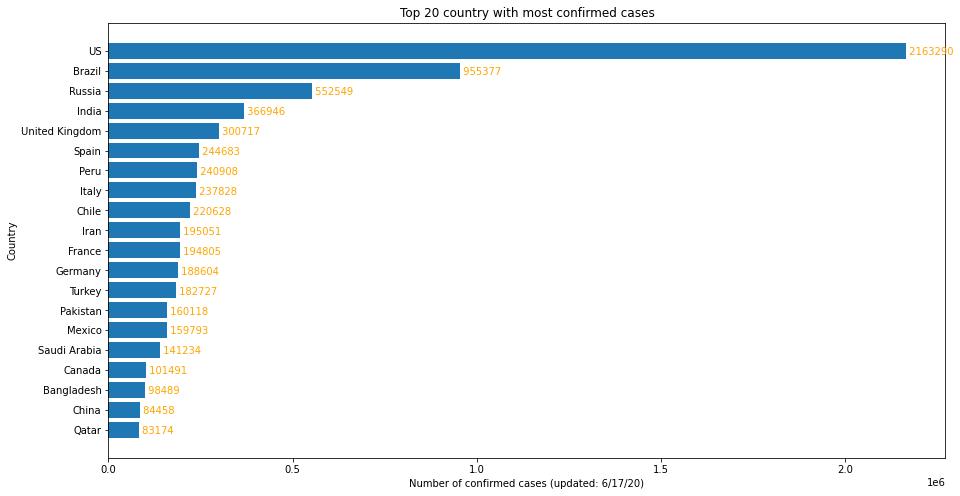

In [9]:
# Sum the amount of cases in different state group by country
df_confirmed_country = df_confirmed.groupby('Country/Region')[dates].sum().reset_index()
df_confirmed_country = df_confirmed_country.sort_values(by=df_confirmed_country.columns[-1], ascending=False)

# Plot the chart for top 20 most confirmed cases
plt.figure(figsize=(15,8))
plt.barh(df_confirmed_country[df_confirmed_country.columns[0]].iloc[:20][::-1], 
         df_confirmed_country[df_confirmed_country.columns[-1]].iloc[:20][::-1])
for i, v in enumerate(df_confirmed_country[df_confirmed_country.columns[-1]].iloc[:20][::-1]):
    plt.text(v, i-.2, ' '+str(v), color='orange')
plt.title('Top 20 country with most confirmed cases')
plt.ylabel('Country')
plt.xlabel(f'Number of confirmed cases (updated: {df_confirmed_country.columns[-1]})')

Text(0.5, 0, 'Number of death cases (updated: 6/17/20)')

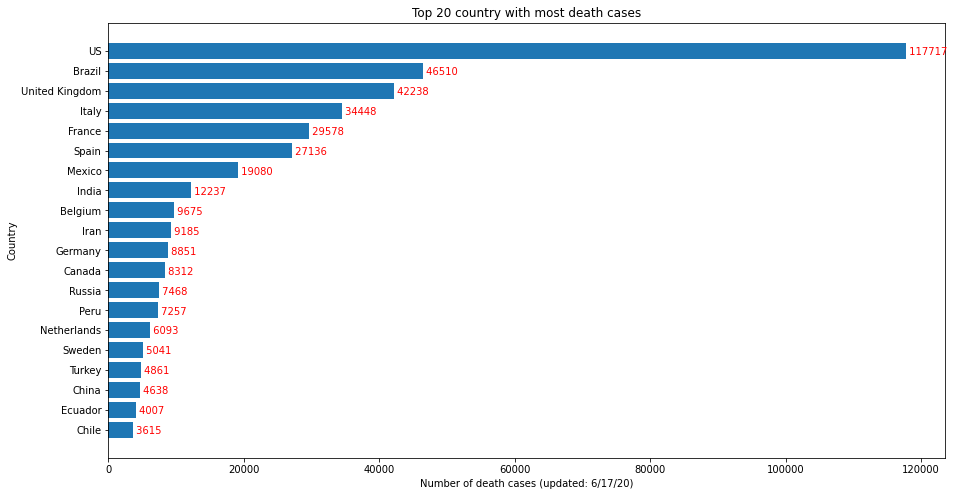

In [10]:
# Sum the amount of cases in different state group by country
df_death_country = df_death.groupby('Country/Region')[dates].sum().reset_index()
df_death_country = df_death_country.sort_values(by=df_death_country.columns[-1], ascending=False)

# Plot the chart for top 20 most death cases
plt.figure(figsize=(15,8))
plt.barh(df_death_country[df_death_country.columns[0]].iloc[:20][::-1], 
         df_death_country[df_death_country.columns[-1]].iloc[:20][::-1])
for i, v in enumerate(df_death_country[df_death_country.columns[-1]].iloc[:20][::-1]):
    plt.text(v, i-.2, ' '+str(v), color='red')
plt.title('Top 20 country with most death cases')
plt.ylabel('Country')
plt.xlabel(f'Number of death cases (updated: {df_death_country.columns[-1]})')

Text(0.5, 0, 'Number of recovered cases (updated: 6/17/20)')

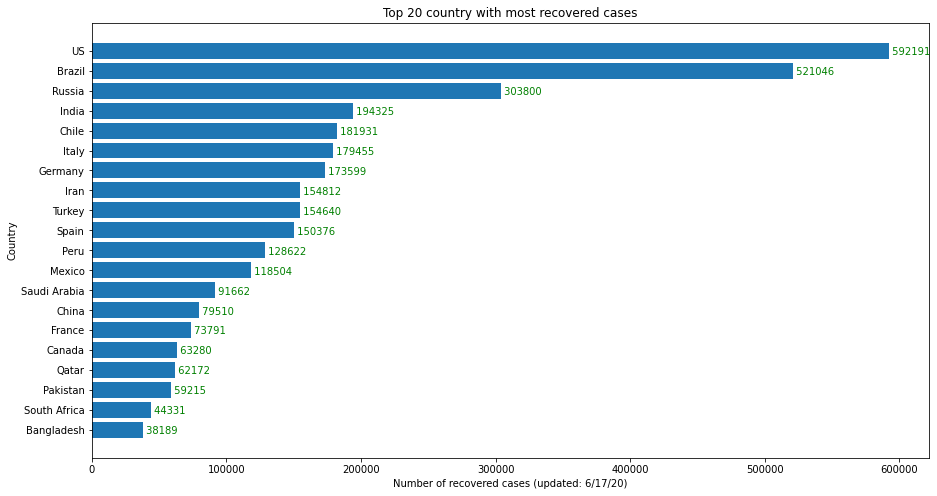

In [11]:
# Sum the amount of cases in different state group by country
df_recovered_country = df_recovered.groupby('Country/Region')[dates].sum().reset_index()
df_recovered_country = df_recovered_country.sort_values(by=df_recovered_country.columns[-1], ascending=False)

# Plot the chart for top 20 most recovered cases
plt.figure(figsize=(15,8))
plt.barh(df_recovered_country[df_recovered_country.columns[0]].iloc[:20][::-1], 
         df_recovered_country[df_recovered_country.columns[-1]].iloc[:20][::-1])
for i, v in enumerate(df_recovered_country[df_recovered_country.columns[-1]].iloc[:20][::-1]):
    plt.text(v, i-.2, ' '+str(v), color='green')
plt.title('Top 20 country with most recovered cases')
plt.ylabel('Country')
plt.xlabel(f'Number of recovered cases (updated: {df_recovered_country.columns[-1]})')

Text(0.5, 0, 'Number of daily confirmed cases')

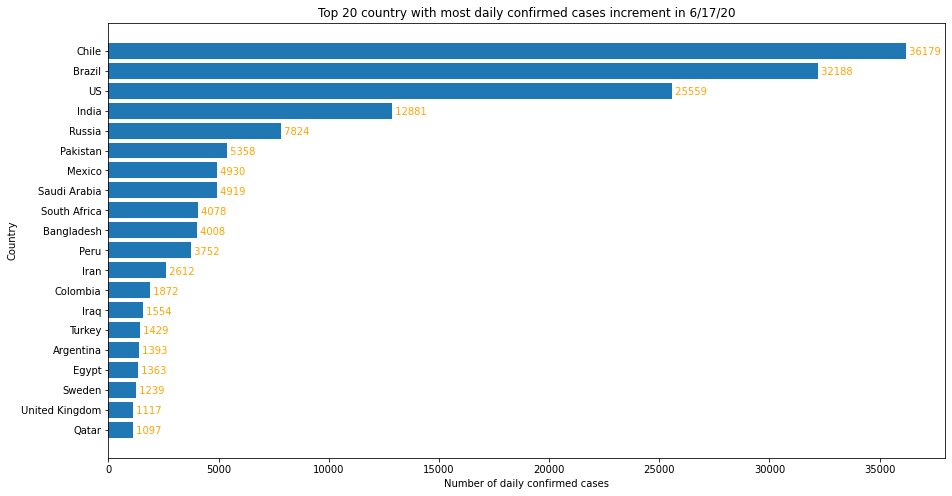

In [12]:
# Plot the chart for top 20 most daily confirmed cases
plt.figure(figsize=(15,8))
df_confirmed_daily = df_confirmed_country.copy()
daily_date = df_confirmed_daily.columns[-1]
df_confirmed_daily['latest_daily_confirmed'] = (df_confirmed_daily[df_confirmed_daily.columns[-1]]
                                          - df_confirmed_daily[df_confirmed_daily.columns[-2]])
df_confirmed_daily = df_confirmed_daily[['Country/Region', 'latest_daily_confirmed']].sort_values(by=['latest_daily_confirmed'], ascending=False)
plt.barh(df_confirmed_daily[df_confirmed_daily.columns[0]].iloc[:20][::-1], 
         df_confirmed_daily[df_confirmed_daily.columns[-1]].iloc[:20][::-1])
for i, v in enumerate(df_confirmed_daily[df_confirmed_daily.columns[-1]].iloc[:20][::-1]):
    plt.text(v, i-.2, ' '+str(v), color='orange')
plt.title(f'Top 20 country with most daily confirmed cases increment in {daily_date}')
plt.ylabel('Country')
plt.xlabel(f'Number of daily confirmed cases')

Text(0.5, 0, 'Number of daily death cases')

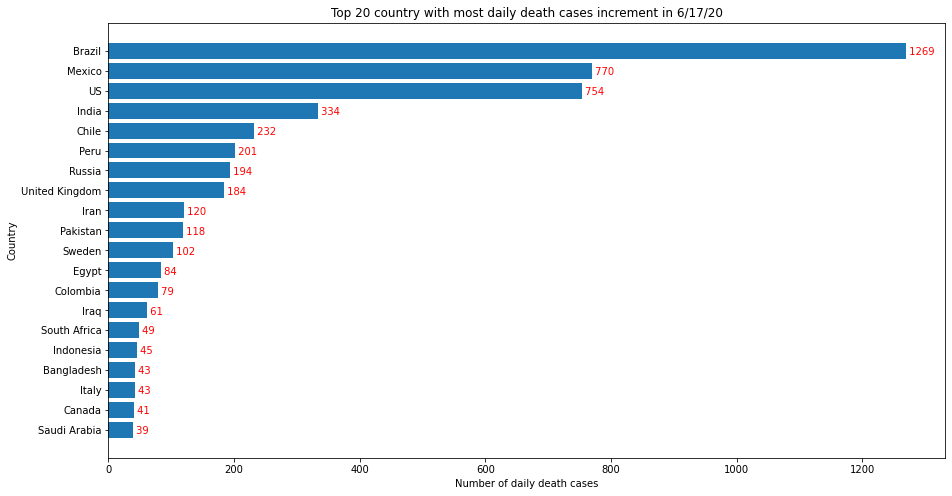

In [13]:
# Plot the chart for top 20 most daily death cases
plt.figure(figsize=(15,8))
df_death_daily = df_death_country.copy()
daily_date = df_death_daily.columns[-1]
df_death_daily['latest_daily_death'] = (df_death_daily[df_death_daily.columns[-1]]
                                          - df_death_daily[df_death_daily.columns[-2]])
df_death_daily = df_death_daily[['Country/Region', 'latest_daily_death']].sort_values(by=['latest_daily_death'], ascending=False)
plt.barh(df_death_daily[df_death_daily.columns[0]].iloc[:20][::-1], 
         df_death_daily[df_death_daily.columns[-1]].iloc[:20][::-1])
for i, v in enumerate(df_death_daily[df_death_daily.columns[-1]].iloc[:20][::-1]):
    plt.text(v, i-.2, ' '+str(v), color='red')
plt.title(f'Top 20 country with most daily death cases increment in {daily_date}')
plt.ylabel('Country')
plt.xlabel(f'Number of daily death cases')

Text(0.5, 0, 'Number of daily recovered cases')

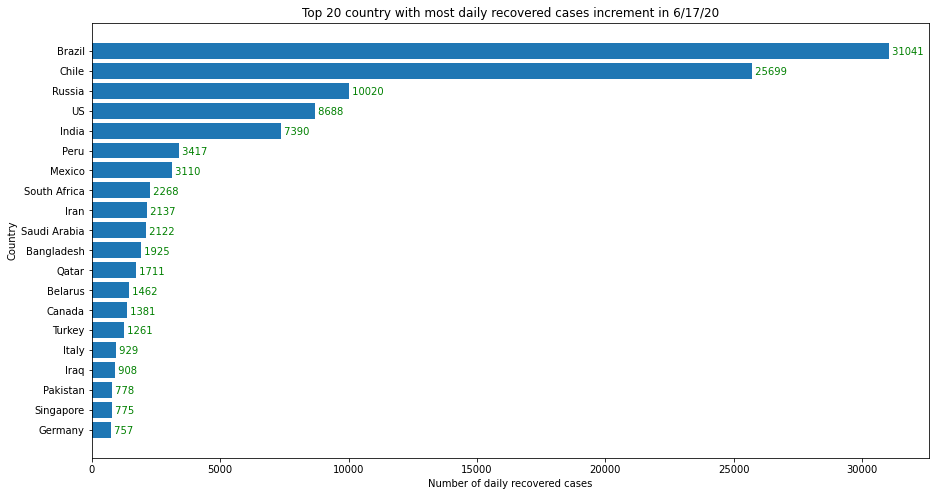

In [14]:
# Plot the chart for top 20 most daily death cases
plt.figure(figsize=(15,8))
df_recovered_daily = df_recovered_country.copy()
daily_date = df_recovered_daily.columns[-1]
df_recovered_daily['latest_daily_recovered'] = (df_recovered_daily[df_recovered_daily.columns[-1]]
                                          - df_recovered_daily[df_recovered_daily.columns[-2]])
df_recovered_daily = df_recovered_daily[['Country/Region', 'latest_daily_recovered']].sort_values(by=['latest_daily_recovered'], ascending=False)
plt.barh(df_recovered_daily[df_recovered_daily.columns[0]].iloc[:20][::-1], 
         df_recovered_daily[df_recovered_daily.columns[-1]].iloc[:20][::-1])
for i, v in enumerate(df_recovered_daily[df_recovered_daily.columns[-1]].iloc[:20][::-1]):
    plt.text(v, i-.2, ' '+str(v), color='green')
plt.title(f'Top 20 country with most daily recovered cases increment in {daily_date}')
plt.ylabel('Country')
plt.xlabel(f'Number of daily recovered cases')

In [15]:
# Aggregate the latest number for confirmed, death and recovered cases for each country
df_agg = df_confirmed_country.iloc[:,[0,-1]].rename(columns={'Country/Region':'country',dates[-1]:'confirmed'})
df_agg = df_agg.join(df_death_country.iloc[:,[0,-1]].set_index('Country/Region'), 
                     on='country').rename(columns={dates[-1]:'death'})
df_agg = df_agg.join(df_recovered_country.iloc[:,[0,-1]].set_index('Country/Region'), 
                     on='country').rename(columns={dates[-1]:'recovered'})
df_agg.head(2)

,country,confirmed,death,recovered
174,US,2163290,117717,592191
23,Brazil,955377,46510,521046


In [16]:
# Calculate the current active cases and rate of death and recovered
df_agg['current_active'] = df_agg['confirmed'] - df_agg['death'] - df_agg['recovered']
df_agg['death_rate'] = round((df_agg['death'] / df_agg['confirmed']) * 100, 2)
df_agg['recovered_rate'] = round((df_agg['recovered'] / df_agg['confirmed']) * 100, 2)
df_agg.head(2)

,country,confirmed,death,recovered,current_active,death_rate,recovered_rate
174,US,2163290,117717,592191,1453382,5.44,27.37
23,Brazil,955377,46510,521046,387821,4.87,54.54


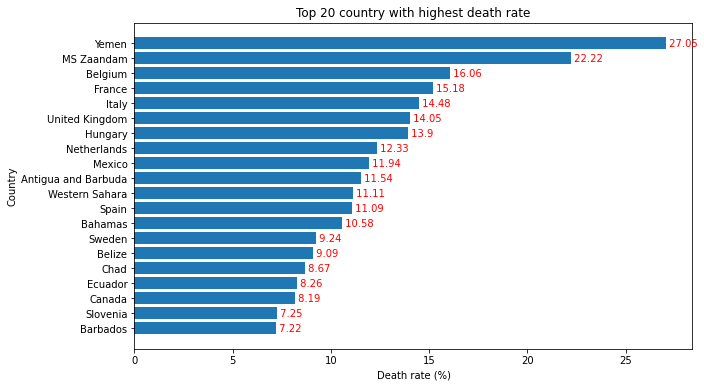

In [17]:
df_agg.sort_values(by='death_rate', inplace=True)

# Plot top 20 highest death rate
plt.figure(figsize=(10,6))
plt.barh(df_agg['country'].iloc[-20:], df_agg['death_rate'].iloc[-20:])
plt.title("Top 20 country with highest death rate")
plt.xlabel("Death rate (%)")
plt.ylabel("Country")

for i, v in enumerate(df_agg['death_rate'].iloc[-20:]):
    plt.text(v, i-.2, ' '+str(v), color='red')

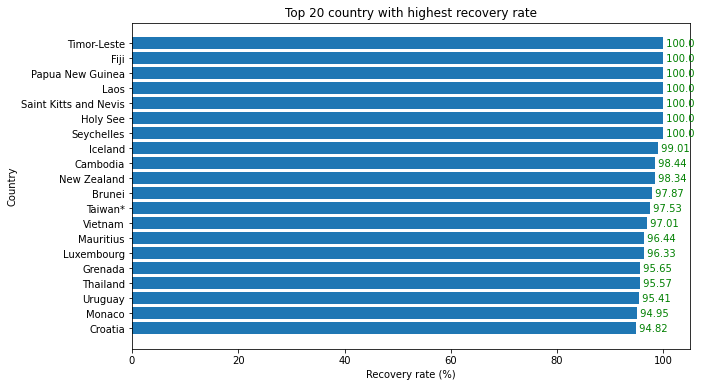

In [18]:
df_agg.sort_values(by='recovered_rate', inplace=True)

# Plot top 20 highest recovery rate
plt.figure(figsize=(10,6))
plt.barh(df_agg['country'].iloc[-20:], df_agg['recovered_rate'].iloc[-20:])
plt.title("Top 20 country with highest recovery rate")
plt.xlabel("Recovery rate (%)")
plt.ylabel("Country")

for i, v in enumerate(df_agg['recovered_rate'].iloc[-20:]):
    plt.text(v, i-.2, ' '+str(v), color='green')

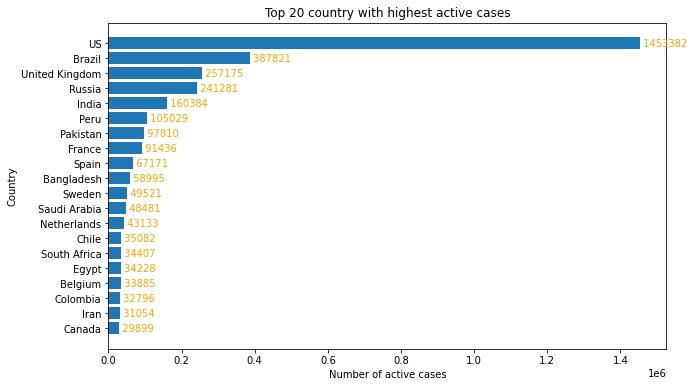

In [19]:
df_agg.sort_values(by='current_active', inplace=True)

# Plot top 20 highest active case
plt.figure(figsize=(10,6))
plt.barh(df_agg['country'].iloc[-20:], df_agg['current_active'].iloc[-20:])
plt.title("Top 20 country with highest active cases")
plt.xlabel("Number of active cases")
plt.ylabel("Country")

for i, v in enumerate(df_agg['current_active'].iloc[-20:]):
    plt.text(v, i-.2, ' '+str(v), color='orange')

In [20]:
df_agg.sort_values(by='current_active', ascending=False, inplace=True)
df_agg.style.background_gradient(cmap='Reds')

,country,confirmed,death,recovered,current_active,death_rate,recovered_rate
174,US,2163290,117717,592191,1453382,5.440000,27.370000
23,Brazil,955377,46510,521046,387821,4.870000,54.540000
178,United Kingdom,300717,42238,1304,257175,14.050000,0.430000
140,Russia,552549,7468,303800,241281,1.350000,54.980000
79,India,366946,12237,194325,160384,3.330000,52.960000
134,Peru,240908,7257,128622,105029,3.010000,53.390000
130,Pakistan,160118,3093,59215,97810,1.930000,36.980000
62,France,194805,29578,73791,91436,15.180000,37.880000
158,Spain,244683,27136,150376,67171,11.090000,61.460000
13,Bangladesh,98489,1305,38189,58995,1.330000,38.770000


### Malaysia Cases Analytic

In [21]:
# Extract Malaysia time series data
my_confirmed = df_confirmed[df_confirmed['Country/Region'] == 'Malaysia'][dates].values.flatten()
my_recovered = df_recovered[df_recovered['Country/Region'] == 'Malaysia'][dates].values.flatten()
my_death = df_death[df_death['Country/Region'] == 'Malaysia'][dates].values.flatten()
my_active = my_confirmed - my_recovered - my_death

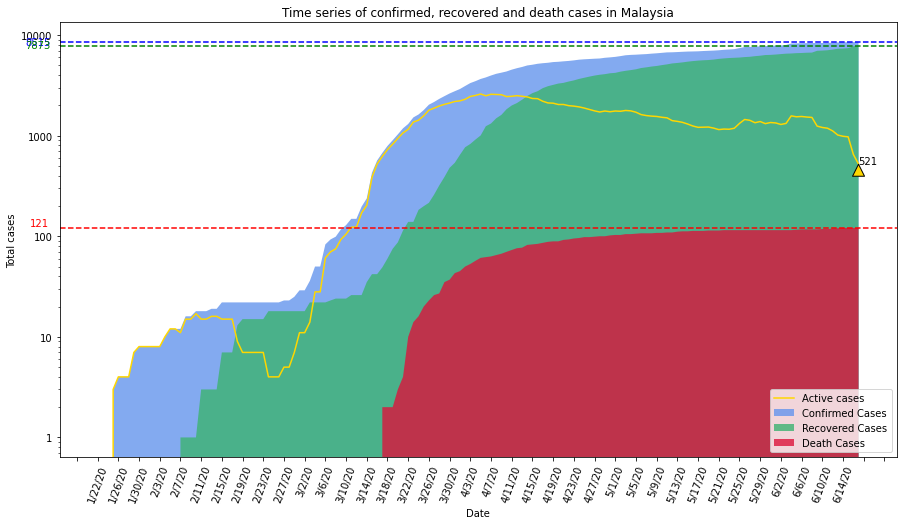

In [22]:
# Plot chart of cases in Malaysia
plt.figure(figsize=(15,8))

plt.fill_between(dates, my_confirmed, facecolor='cornflowerBlue', alpha=0.8, label='Confirmed Cases')
plt.fill_between(dates, my_recovered, facecolor='mediumSeaGreen', alpha=0.8, label='Recovered Cases')
plt.fill_between(dates, my_death, facecolor='crimson', alpha=0.8, label='Death Cases')
plt.plot(dates, my_active, color='gold', label='Active cases')

plt.axhline(y=my_confirmed[-1], color='blue', linestyle='--')
plt.axhline(y=my_recovered[-1], color='green', linestyle='--')
plt.axhline(y=my_death[-1], color='red', linestyle='--')
plt.text(int(len(dates)/-10), my_confirmed[-1], my_confirmed[-1], color='blue', va='center')
plt.text(int(len(dates)/-10), my_recovered[-1], my_recovered[-1], color='green', va='center')
plt.text(int(len(dates)/-11), my_death[-1] + 5, my_death[-1], color='red')
plt.annotate(s=my_active[-1], xy=(dates[-1], my_active[-1]), arrowprops=dict(facecolor='gold', shrink=0.05))

plt.yscale('log')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=50))
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.xticks(rotation=70)
plt.title('Time series of confirmed, recovered and death cases in Malaysia')
plt.xlabel('Date')
plt.ylabel('Total cases')
plt.legend()

## Prediction

### Predictive Model for Malaysia cases

In [44]:
# previous sequences used in LSTM
prev_day = 15

In [45]:
def gru_model(sequence):
  keras.backend.clear_session()

  in_data = keras.Input((sequence, 1),dtype='float32')

  X = keras.layers.GRU(256, return_sequences=True)(in_data)
  # X = keras.layers.Dropout(0.2)(X)
  X = keras.layers.GRU(128, return_sequences=True)(X)
  # X = keras.layers.Flatten()(X)
  # X = keras.layers.Dropout(0.2)(X)
  X = keras.layers.GRU(64)(X)
  # X = keras.layers.Dropout(0.2)(X)
  X = keras.layers.Dense(128, activation='relu')(X)
  X = keras.layers.Dense(64, activation='relu')(X)
  X = keras.layers.Dense(1, activation='relu')(X)

  # Create Model instance which converts sentence_indices into X.
  model = keras.models.Model(inputs=in_data, outputs=X)
  print(model.summary())
  return model

In [46]:
# Create training input for lstm
sample_confirmed = np.pad(my_confirmed, (prev_day,0), 'constant', constant_values=0).reshape(my_confirmed.shape[0]+prev_day, 1)
sample_confirmed = [sample_confirmed[i:i+prev_day]for i in range(0, len(sample_confirmed)-prev_day,1)]
sample_confirmed = np.array(sample_confirmed).reshape(len(sample_confirmed),prev_day,1).astype(float)
sample_recovered = np.pad(my_recovered, (prev_day,0), 'constant', constant_values=0).reshape(my_recovered.shape[0]+prev_day, 1)
sample_recovered = [sample_recovered[i:i+prev_day]for i in range(0, len(sample_recovered)-prev_day,1)]
sample_recovered = np.array(sample_recovered).reshape(len(sample_recovered),prev_day,1).astype(float)
sample_death = np.pad(my_death, (prev_day,0), 'constant', constant_values=0).reshape(my_death.shape[0]+prev_day, 1)
sample_death = [sample_death[i:i+prev_day]for i in range(0, len(sample_death)-prev_day,1)]
sample_death = np.array(sample_death).reshape(len(sample_death),prev_day,1).astype(float)
# features = np.concatenate((sample_confirmed, sample_recovered, sample_death), axis=2)

# Create training input for ff network
# sample_confirmed = np.array(my_confirmed).reshape(len(my_confirmed),1).astype(float)
# sample_recovered = np.array(my_recovered).reshape(len(my_recovered),1).astype(float)
# sample_death = np.array(my_death).reshape(len(my_death),1).astype(float)
# features = np.concatenate((sample_confirmed, sample_recovered, sample_death), axis=1)

# Create label
label_confirmed = np.array(my_confirmed).reshape(len(my_confirmed),1).astype(float)
label_recovered = np.array(my_recovered).reshape(len(my_recovered),1).astype(float)
label_death = np.array(my_death).reshape(len(my_death),1).astype(float)
# label = np.concatenate((label_confirmed, label_recovered, label_death), axis=1)

# X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.1)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# X_train = features[:-1]
# y_train = label[1:]
# # X_train, y_train = shuffle(X_train, y_train)
# print(X_train.shape, y_train.shape)
print(f'Confirmed -> sample shape: {sample_confirmed.shape} label shape: {label_confirmed.shape}')
print(f'Recovered -> sample shape: {sample_recovered.shape} label shape: {label_recovered.shape}')
print(f'Death -> sample shape: {sample_death.shape} label shape: {label_death.shape}')

Confirmed -> sample shape: (148, 15, 1) label shape: (148, 1)
Recovered -> sample shape: (148, 15, 1) label shape: (148, 1)
Death -> sample shape: (148, 15, 1) label shape: (148, 1)


##### Confirmed cases model

In [47]:
model_confirmed = gru_model(prev_day)
model_confirmed.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 1)]           0         
_________________________________________________________________
gru (GRU)                    (None, 15, 256)           198912    
_________________________________________________________________
gru_1 (GRU)                  (None, 15, 128)           148224    
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65    

In [48]:
epochs = 1500
batch_size = 64
mh_confirmed = {
    'loss': [],
    'val_loss': []
}

Epoch 150 -> loss: [38501.9296875] val_loss: [35588.92578125]
Epoch 300 -> loss: [72755.296875] val_loss: [66718.4765625]
Epoch 450 -> loss: [44140.39453125] val_loss: [93364.296875]
Epoch 600 -> loss: [92657.7890625] val_loss: [209668.59375]
Epoch 750 -> loss: [3596.061767578125] val_loss: [3756.743896484375]
Epoch 900 -> loss: [33745.078125] val_loss: [103954.546875]
Epoch 1050 -> loss: [51214.84375] val_loss: [95628.359375]
Epoch 1200 -> loss: [35311.84765625] val_loss: [33486.44921875]
Epoch 1350 -> loss: [3778.504150390625] val_loss: [8619.4560546875]
Epoch 1500 -> loss: [88265.109375] val_loss: [34060.9921875]



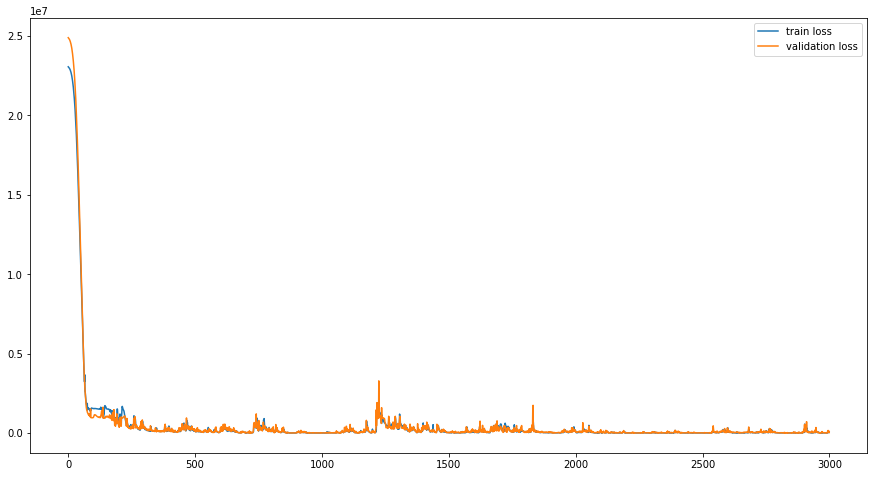

In [65]:
shuffled_sample_confirmed, shuffled_label_confirmed = shuffle(sample_confirmed, label_confirmed)
for i in tqdm(range(epochs)):
  history = model_confirmed.fit(x=shuffled_sample_confirmed, y=shuffled_label_confirmed, 
                      epochs=1, 
                      batch_size=batch_size, 
                      validation_split=0.1,
                      shuffle=True,
                      verbose=0)
  mh_confirmed['loss'].append(history.history['loss'])
  mh_confirmed['val_loss'].append(history.history['val_loss'])
  if((int((i+1)%(epochs/10)) == 0) or (i == (epochs-1))):
    print(f"Epoch {i+1} -> loss: {history.history['loss']} val_loss: {history.history['val_loss']}")

# Plot model traning loss
plt.figure(figsize=(15,8))
plt.plot(mh_confirmed['loss'], label='train loss')
plt.plot(mh_confirmed['val_loss'], label='validation loss')
plt.legend()

In [66]:
pred_confirmed = model_confirmed.predict(sample_confirmed)

# Forecasting day
forecast_days = 30

pred_feature = sample_confirmed[-1:]
pred_feature = np.concatenate((pred_feature[:,1:,:], pred_confirmed[-1].reshape((1,1,1))),axis=1)
# pred_feature = pred_confirmed[-1:]
pred_date = dates


for day in range(forecast_days):
    pred = model_confirmed.predict(pred_feature)
    pred_confirmed = np.concatenate((pred_confirmed, pred), axis=0)
    pred_date = pred_date + [(datetime.strptime(pred_date[-1], '%x') + timedelta(days=1)).strftime("%x")]
    pred_feature = np.concatenate((pred_feature[:,1:,:], pred.reshape((1,1,1))),axis=1) 
    # pred_feature = pred_confirmed[-1:]
    

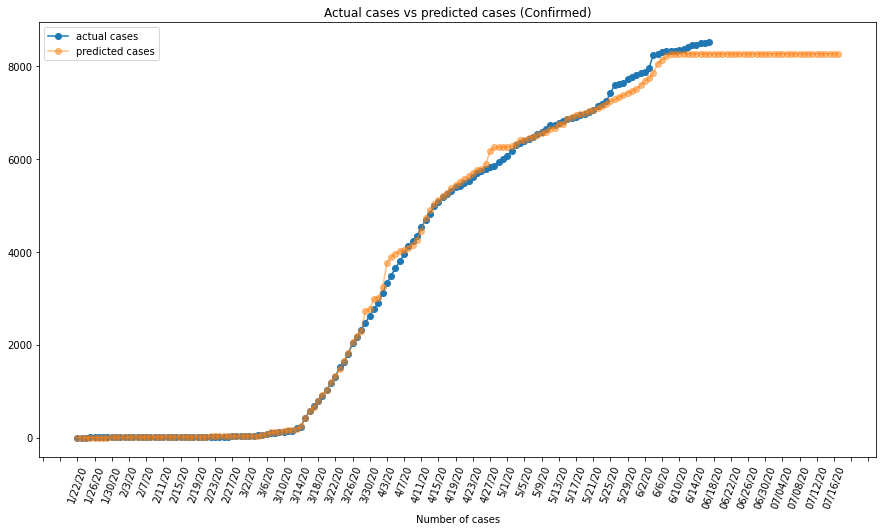

In [67]:
plt.figure(figsize=(15,8))
plt.plot(dates, my_confirmed, marker='o', label='actual cases')
plt.plot(pred_date, pred_confirmed, marker='o', label='predicted cases', alpha=0.5)
plt.title("Actual cases vs predicted cases (Confirmed)")
plt.xlabel('Date')
plt.xlabel('Number of cases')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=50))
plt.xticks(rotation=70)
plt.legend()

In [52]:
# model_confirmed.save(f'{WORKING_DIR}/saved_model/model_confirmed')

##### Recovered cases model

In [53]:
model_recovered = gru_model(prev_day)
model_recovered.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 1)]           0         
_________________________________________________________________
gru (GRU)                    (None, 15, 256)           198912    
_________________________________________________________________
gru_1 (GRU)                  (None, 15, 128)           148224    
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65    

In [54]:
epochs = 1500
batch_size = 64
mh_recovered = {
    'loss': [],
    'val_loss': []
}

Epoch 1/1500
3/3 [==============================] - 0s 16ms/step - loss: 16471.1230 - val_loss: 2040.8929
Epoch 2/1500
3/3 [==============================] - 0s 14ms/step - loss: 19642.8672 - val_loss: 9127.9756
Epoch 3/1500
3/3 [==============================] - 0s 14ms/step - loss: 27430.6699 - val_loss: 25864.2617
Epoch 4/1500
3/3 [==============================] - 0s 15ms/step - loss: 31186.0410 - val_loss: 32444.2227
Epoch 5/1500
3/3 [==============================] - 0s 16ms/step - loss: 49842.1953 - val_loss: 22151.5410
Epoch 6/1500
3/3 [==============================] - 0s 16ms/step - loss: 29358.2891 - val_loss: 12645.8955
Epoch 7/1500
3/3 [==============================] - 0s 16ms/step - loss: 16319.7012 - val_loss: 12773.0107
Epoch 8/1500
3/3 [==============================] - 0s 14ms/step - loss: 20585.0156 - val_loss: 40522.2031
Epoch 9/1500
3/3 [==============================] - 0s 19ms/step - loss: 51339.1094 - val_loss: 17059.4883
Epoch 10/1500
3/3 [====================

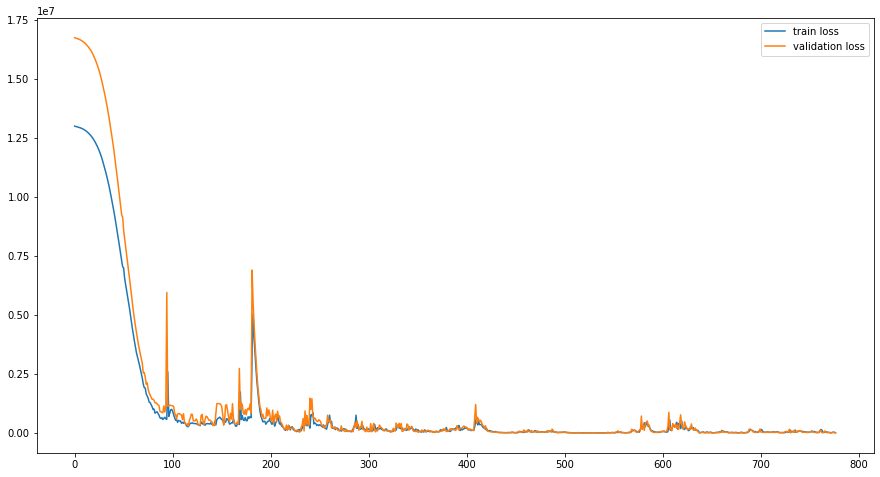

In [68]:
shuffled_sample_recovered, shuffled_label_recovered = shuffle(sample_recovered, label_recovered)
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=100,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
history = model_recovered.fit(x=shuffled_sample_recovered, y=shuffled_label_recovered, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split=0.1,
                    shuffle=True,
                    callbacks=[early_stopping_monitor],
                    verbose=1)

mh_recovered['loss'].extend(history.history['loss'])
mh_recovered['val_loss'].extend(history.history['val_loss'])

# Plot model traning loss
plt.figure(figsize=(15,8))
plt.plot(mh_recovered['loss'], label='train loss')
plt.plot(mh_recovered['val_loss'], label='validation loss')
plt.legend()

In [69]:
pred_recovered = model_recovered.predict(sample_recovered)

# Forecasting day
forecast_days = 30

pred_feature = sample_recovered[-1:]
pred_feature = np.concatenate((pred_feature[:,1:,:], pred_recovered[-1].reshape((1,1,1))),axis=1)
pred_date = dates


for day in range(forecast_days):
    pred = model_recovered.predict(pred_feature)
    pred_recovered = np.concatenate((pred_recovered, pred), axis=0)
    pred_date = pred_date + [(datetime.strptime(pred_date[-1], '%x') + timedelta(days=1)).strftime("%x")]
    pred_feature = np.concatenate((pred_feature[:,1:,:], pred.reshape((1,1,1))),axis=1) 

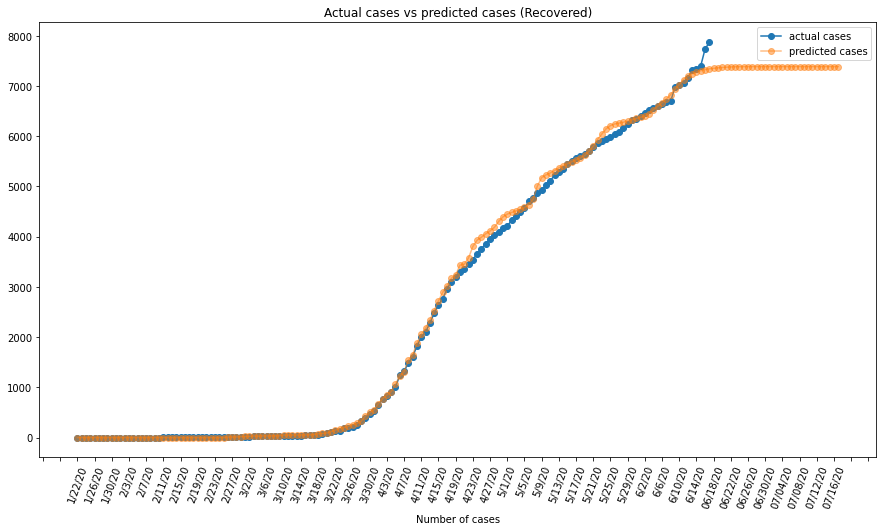

In [70]:
plt.figure(figsize=(15,8))
plt.plot(dates, my_recovered, marker='o', label='actual cases')
plt.plot(pred_date, pred_recovered, marker='o', label='predicted cases', alpha=0.5)
plt.title("Actual cases vs predicted cases (Recovered)")
plt.xlabel('Date')
plt.xlabel('Number of cases')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=50))
plt.xticks(rotation=70)
plt.legend()

In [58]:
# model_recovered.save(f'{WORKING_DIR}/saved_model/model_recovered')

##### Death cases model

In [77]:
model_death = gru_model(prev_day)
model_death.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 1)]           0         
_________________________________________________________________
gru (GRU)                    (None, 15, 256)           198912    
_________________________________________________________________
gru_1 (GRU)                  (None, 15, 128)           148224    
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65    

In [78]:
epochs = 1500
batch_size = 64
mh_death = {
    'loss': [],
    'val_loss': []
}

Epoch 1/1500
3/3 [==============================] - 1s 251ms/step - loss: 5493.3340 - val_loss: 5827.3979
Epoch 2/1500
3/3 [==============================] - 0s 17ms/step - loss: 5293.4595 - val_loss: 5604.4292
Epoch 3/1500
3/3 [==============================] - 0s 17ms/step - loss: 5083.4531 - val_loss: 5384.9580
Epoch 4/1500
3/3 [==============================] - 0s 17ms/step - loss: 4877.5366 - val_loss: 5153.1533
Epoch 5/1500
3/3 [==============================] - 0s 15ms/step - loss: 4660.6538 - val_loss: 4907.8613
Epoch 6/1500
3/3 [==============================] - 0s 16ms/step - loss: 4431.9639 - val_loss: 4650.1074
Epoch 7/1500
3/3 [==============================] - 0s 15ms/step - loss: 4189.2280 - val_loss: 4363.6089
Epoch 8/1500
3/3 [==============================] - 0s 15ms/step - loss: 3927.1824 - val_loss: 4044.1885
Epoch 9/1500
3/3 [==============================] - 0s 17ms/step - loss: 3640.3594 - val_loss: 3699.4954
Epoch 10/1500
3/3 [==============================] - 0

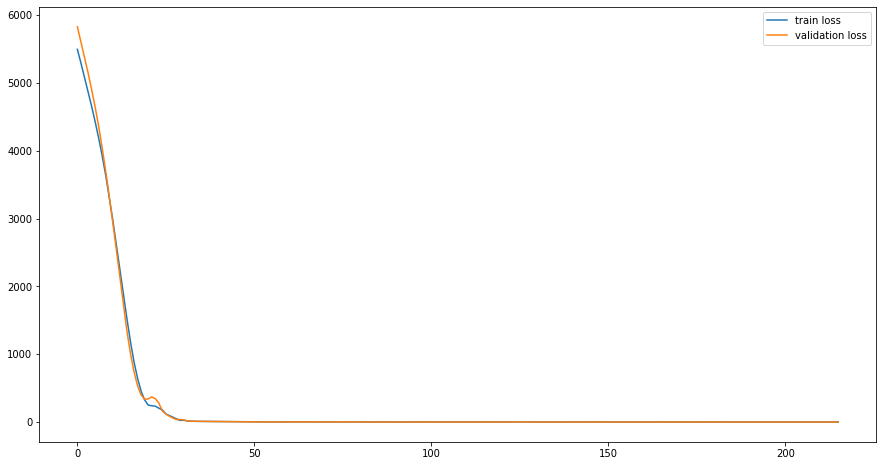

In [79]:
shuffled_sample_death, shuffled_label_death = shuffle(sample_death, label_death)
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=100,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
history = model_death.fit(x=shuffled_sample_death, y=shuffled_label_death, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split=0.1,
                    shuffle=True,
                    callbacks=[early_stopping_monitor],
                    verbose=1)

mh_death['loss'].extend(history.history['loss'])
mh_death['val_loss'].extend(history.history['val_loss'])

# Plot model traning loss
plt.figure(figsize=(15,8))
plt.plot(mh_death['loss'], label='train loss')
plt.plot(mh_death['val_loss'], label='validation loss')
plt.legend()

In [80]:
pred_death = model_death.predict(sample_death)

# Forecasting day
forecast_days = 30

pred_feature = sample_death[-1:]
pred_feature = np.concatenate((pred_feature[:,1:,:], pred_death[-1].reshape((1,1,1))),axis=1)
pred_date = dates


for day in range(forecast_days):
    pred = model_death.predict(pred_feature)
    pred_death = np.concatenate((pred_death, pred), axis=0)
    pred_date = pred_date + [(datetime.strptime(pred_date[-1], '%x') + timedelta(days=1)).strftime("%x")]
    pred_feature = np.concatenate((pred_feature[:,1:,:], pred.reshape((1,1,1))),axis=1) 

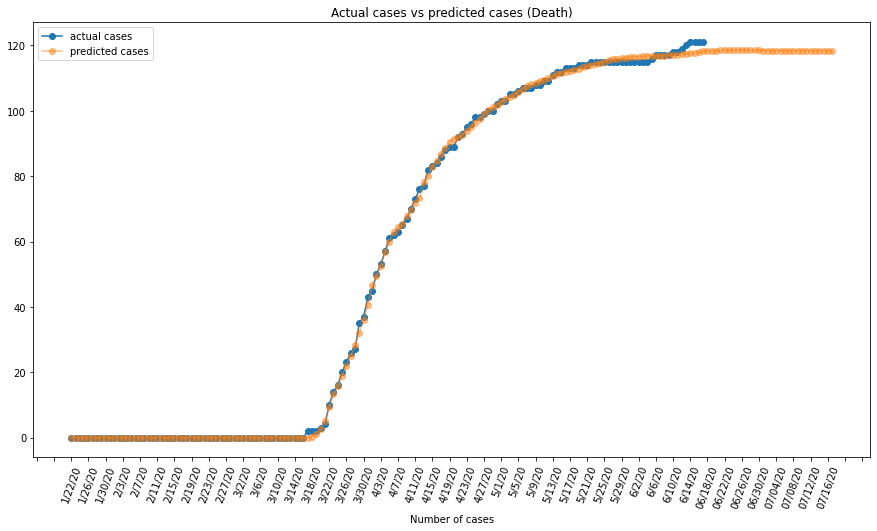

In [81]:
plt.figure(figsize=(15,8))
plt.plot(dates, my_death, marker='o', label='actual cases')
plt.plot(pred_date, pred_death, marker='o', label='predicted cases', alpha=0.5)
plt.title("Actual cases vs predicted cases (Death)")
plt.xlabel('Date')
plt.xlabel('Number of cases')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=50))
plt.xticks(rotation=70)
plt.legend()

In [82]:
# model_death.save(f'{WORKING_DIR}/saved_model/model_death')